In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from cuml.ensemble import RandomForestRegressor as cuRF
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scripts.function_utils import correct_wind_direction, test_leave_house_out, total_averaged_metrics, add_energy_variation, past_timesteps

#### Output file

In [2]:
sourceFile = open("../../gpu_logs/discard.txt", 'w')

### Load the data

In [3]:
merged = pd.read_csv("../../data/loureiro_complete.csv")
#merged = correct_wind_direction(merged).drop(["Temp_Max","Temp_Min","Rumo_Vento_Med", "Rumo_Vento_Max", "Intensidade_Vento_Max"], axis=1)
merged.Time = pd.to_datetime(merged.Time)
merged

,Time,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,...,Energy_163,Energy_164,Energy_165,Energy_166,Energy_167,Energy_168,Energy_169,Energy_170,Energy_171,Energy_172
0,2022-05-05 12:00:00,22.70,62.0,305.0,3.80,5.40,24.40,0.0,0.0,526.00,...,NaN,0.004,0.0,NaN,NaN,NaN,0.395,NaN,NaN,0.008
1,2022-05-05 12:15:00,22.55,63.5,311.5,4.05,5.70,24.55,0.0,0.0,523.35,...,NaN,0.003,0.0,NaN,NaN,NaN,0.316,NaN,NaN,0.056
2,2022-05-05 12:30:00,22.10,64.0,311.0,4.10,6.00,24.80,0.0,0.0,520.00,...,NaN,0.004,0.0,NaN,NaN,NaN,0.264,NaN,NaN,0.033
3,2022-05-05 12:45:00,21.95,62.5,300.0,4.45,6.05,24.90,0.0,0.0,514.40,...,NaN,0.004,0.0,NaN,NaN,NaN,0.139,NaN,NaN,0.062
4,2022-05-05 13:00:00,22.20,62.0,314.0,4.00,5.20,24.90,0.0,0.0,507.00,...,NaN,0.004,0.0,NaN,NaN,NaN,0.138,NaN,NaN,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46603,2023-09-02 22:45:00,19.25,84.5,281.5,0.95,1.70,21.55,0.0,0.0,0.00,...,0.066,0.003,0.0,0.009,0.043,0.217,0.189,NaN,0.071,0.055
46604,2023-09-02 23:00:00,19.10,82.0,163.0,1.30,2.30,21.50,0.0,0.0,0.00,...,0.066,0.004,0.0,0.008,0.042,0.242,0.171,NaN,0.072,0.062
46605,2023-09-02 23:15:00,19.05,80.0,59.5,1.60,2.45,21.10,0.0,0.0,0.00,...,0.066,0.003,0.0,0.006,0.056,0.239,0.186,NaN,0.068,0.023
46606,2023-09-02 23:30:00,19.30,75.0,26.0,1.10,1.80,20.90,0.0,0.0,0.00,...,0.066,0.004,0.0,0.007,0.039,0.201,0.215,NaN,0.063,0.035


In [3]:
missing_values = merged.isna().sum()
selected_columns = merged.columns[np.where(missing_values <= 6000)]
df = merged[selected_columns]
print(df.isna().sum())
df

Time                     0
Avg_Temp                 6
Avg_Rel_Humidity         6
Avg_Wind_Direction       0
Avg_Wind_Speed           0
                      ... 
Energy_159            5352
Energy_160            5033
Energy_161            4922
Energy_164            4830
Energy_172            5739
Length: 69, dtype: int64


,Time,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,...,Energy_144,Energy_146,Energy_148,Energy_151,Energy_156,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,22.70,62.0,305.0,3.80,5.40,24.40,0.0,0.0,526.00,...,0.0,0.068,0.060,0.042,NaN,NaN,0.069,NaN,0.004,0.008
1,2022-05-05 12:15:00,22.55,63.5,311.5,4.05,5.70,24.55,0.0,0.0,523.35,...,0.0,0.048,0.078,0.053,NaN,NaN,0.063,NaN,0.003,0.056
2,2022-05-05 12:30:00,22.10,64.0,311.0,4.10,6.00,24.80,0.0,0.0,520.00,...,0.0,0.062,0.061,0.057,NaN,NaN,0.049,NaN,0.004,0.033
3,2022-05-05 12:45:00,21.95,62.5,300.0,4.45,6.05,24.90,0.0,0.0,514.40,...,0.0,0.056,0.125,0.034,NaN,NaN,0.097,NaN,0.004,0.062
4,2022-05-05 13:00:00,22.20,62.0,314.0,4.00,5.20,24.90,0.0,0.0,507.00,...,0.0,0.034,0.070,0.038,NaN,NaN,0.075,NaN,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46603,2023-09-02 22:45:00,19.25,84.5,281.5,0.95,1.70,21.55,0.0,0.0,0.00,...,0.0,0.153,0.055,0.136,0.0,0.157,0.111,0.011,0.003,0.055
46604,2023-09-02 23:00:00,19.10,82.0,163.0,1.30,2.30,21.50,0.0,0.0,0.00,...,0.0,0.110,0.039,0.085,0.0,0.141,0.138,0.026,0.004,0.062
46605,2023-09-02 23:15:00,19.05,80.0,59.5,1.60,2.45,21.10,0.0,0.0,0.00,...,0.0,0.085,0.028,0.066,0.0,0.200,0.087,0.019,0.003,0.023
46606,2023-09-02 23:30:00,19.30,75.0,26.0,1.10,1.80,20.90,0.0,0.0,0.00,...,0.0,0.061,0.017,0.069,0.0,0.192,0.081,0.019,0.004,0.035


In [4]:
df_slice = df.iloc[:38016]
print(df_slice.isna().sum())
df = df_slice
df

Time                     0
Avg_Temp                 6
Avg_Rel_Humidity         6
Avg_Wind_Direction       0
Avg_Wind_Speed           0
                      ... 
Energy_159             792
Energy_160             487
Energy_161             434
Energy_164             392
Energy_172            1277
Length: 69, dtype: int64


,Time,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,...,Energy_144,Energy_146,Energy_148,Energy_151,Energy_156,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,22.70,62.0,305.0,3.80,5.40,24.40,0.0,0.0,526.00,...,0.0,0.068,0.060,0.042,NaN,NaN,0.069,NaN,0.004,0.008
1,2022-05-05 12:15:00,22.55,63.5,311.5,4.05,5.70,24.55,0.0,0.0,523.35,...,0.0,0.048,0.078,0.053,NaN,NaN,0.063,NaN,0.003,0.056
2,2022-05-05 12:30:00,22.10,64.0,311.0,4.10,6.00,24.80,0.0,0.0,520.00,...,0.0,0.062,0.061,0.057,NaN,NaN,0.049,NaN,0.004,0.033
3,2022-05-05 12:45:00,21.95,62.5,300.0,4.45,6.05,24.90,0.0,0.0,514.40,...,0.0,0.056,0.125,0.034,NaN,NaN,0.097,NaN,0.004,0.062
4,2022-05-05 13:00:00,22.20,62.0,314.0,4.00,5.20,24.90,0.0,0.0,507.00,...,0.0,0.034,0.070,0.038,NaN,NaN,0.075,NaN,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2023-06-05 10:45:00,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38012,2023-06-05 11:00:00,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38013,2023-06-05 11:15:00,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38014,2023-06-05 11:30:00,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_noweather = df_slice.iloc[:,10:]
df_noweather

,Energy_1,Energy_2,Energy_8,Energy_9,Energy_11,Energy_15,Energy_16,Energy_17,Energy_21,Energy_29,...,Energy_144,Energy_146,Energy_148,Energy_151,Energy_156,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,0.068,NaN,NaN,NaN,0.114,0.164,0.072,0.055,0.0,0.011,...,0.0,0.068,0.060,0.042,NaN,NaN,0.069,NaN,0.004,0.008
1,0.070,NaN,NaN,NaN,0.190,0.135,0.058,0.060,0.0,0.002,...,0.0,0.048,0.078,0.053,NaN,NaN,0.063,NaN,0.003,0.056
2,0.122,NaN,NaN,NaN,0.180,0.121,0.011,0.096,0.0,0.010,...,0.0,0.062,0.061,0.057,NaN,NaN,0.049,NaN,0.004,0.033
3,0.132,NaN,NaN,NaN,0.167,0.138,0.010,0.064,0.0,0.004,...,0.0,0.056,0.125,0.034,NaN,NaN,0.097,NaN,0.004,0.062
4,0.125,NaN,NaN,NaN,0.133,0.104,0.011,0.072,0.0,0.002,...,0.0,0.034,0.070,0.038,NaN,NaN,0.075,NaN,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
zero_values = np.sum(df_noweather == 0)
selected_columns = df_noweather.columns[np.where(zero_values < 5000)]
df_noweather = df_noweather[selected_columns]
df = pd.concat([df.iloc[:,:10],df_noweather], axis=1)
df

,Time,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,...,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,22.70,62.0,305.0,3.80,5.40,24.40,0.0,0.0,526.00,...,0.083,0.084,0.068,0.060,0.042,NaN,0.069,NaN,0.004,0.008
1,2022-05-05 12:15:00,22.55,63.5,311.5,4.05,5.70,24.55,0.0,0.0,523.35,...,0.053,0.004,0.048,0.078,0.053,NaN,0.063,NaN,0.003,0.056
2,2022-05-05 12:30:00,22.10,64.0,311.0,4.10,6.00,24.80,0.0,0.0,520.00,...,0.035,0.004,0.062,0.061,0.057,NaN,0.049,NaN,0.004,0.033
3,2022-05-05 12:45:00,21.95,62.5,300.0,4.45,6.05,24.90,0.0,0.0,514.40,...,0.082,0.004,0.056,0.125,0.034,NaN,0.097,NaN,0.004,0.062
4,2022-05-05 13:00:00,22.20,62.0,314.0,4.00,5.20,24.90,0.0,0.0,507.00,...,0.076,0.004,0.034,0.070,0.038,NaN,0.075,NaN,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2023-06-05 10:45:00,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38012,2023-06-05 11:00:00,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38013,2023-06-05 11:15:00,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38014,2023-06-05 11:30:00,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Interpolate missing values

In [ ]:
df.index = pd.to_datetime(df["Time"])
df.drop(["Time"], inplace=True, axis=1)
for column in df.columns:
    df[column] = df[column].interpolate(method='time', limit_direction="both")
print(df.isna().sum().sum())
df["Time"] = df.index
df.reset_index(drop=True, inplace=True)
column_names = df.columns.tolist()
column_to_move = 'Time'
column_names.remove(column_to_move)
new_column_order = [column_to_move] + column_names
df = df[new_column_order]
df

In [ ]:
pd.concat([df.Time, df.iloc[:,10:]], axis=1).to_csv("../../data/loureiro_45houses.csv", index=None)
#df.to_csv("../../data/loureiro_weather_45houses.csv", index=None)

In [ ]:
np.sum(df == 0)

## Save Dataframe with past timesteps

In [ ]:
df = pd.read_csv("../../data/loureiro_45houses_location.csv")
df.Time = pd.to_datetime(df.Time)
df

In [ ]:
number_of_timesteps = 672

In [ ]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
#df_new.to_csv("../../data/loureiro_45houses_oneweek.csv", index=False)

## Predict  5 folds with 10 random houses for test

In [ ]:
df = pd.read_csv("../../data/loureiro_45houses_oneweek.csv")
df

In [ ]:
df_weather = pd.read_csv("../../data/loureiro_weather_45houses.csv")
df_weather = df_weather.iloc[:,:10]
df_weather

In [ ]:
df_selected = df[["Time","Location","lag_1","lag_2","lag_3","lag_4","lag_96","lag_192","lag_288","lag_384","lag_480","lag_576","lag_672","DayOfWeek","Hour","Energy"]]
df_selected

In [ ]:
df_complete = pd.DataFrame()
for h in df_selected.Location.unique():
    tmp = pd.merge(df_selected[df_selected.Location == h], df_weather, on='Time', how='outer')
    tmp.dropna(inplace=True)
    if df_complete.empty:
        df_complete = tmp
    else:
        df_complete = pd.concat([df_complete, tmp], axis=0)
df_complete.reset_index(drop=True, inplace=True)
tmp = df_complete.Energy
df_complete.drop(['Energy'], axis=1, inplace=True)
df_complete["Energy"] = tmp
df_complete

In [ ]:
#df_complete.to_csv("../../data/loureiro_weather_45houses_selected.csv", index=None)

In [3]:
df = pd.read_csv("../../data/loureiro_weather_45houses_selected.csv")
df

,Time,Location,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,...,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,Energy
0,2022-05-12 12:00:00,Energy_1,0.016,0.058,0.038,0.022,0.041,0.023,0.044,0.033,...,22.30,55.0,348.0,2.40,3.30,26.20,0.0,0.0,547.70,0.039
1,2022-05-12 12:15:00,Energy_1,0.039,0.016,0.058,0.038,0.487,0.034,0.058,0.034,...,21.65,62.0,328.5,3.55,4.80,26.25,0.0,0.0,372.85,0.061
2,2022-05-12 12:30:00,Energy_1,0.061,0.039,0.016,0.058,0.340,0.037,0.038,0.055,...,20.70,67.0,321.0,4.20,5.00,25.60,0.0,0.0,412.80,0.038
3,2022-05-12 12:45:00,Energy_1,0.038,0.061,0.039,0.016,0.058,0.046,0.026,0.058,...,20.20,67.5,325.0,4.15,5.15,25.05,0.0,0.0,282.10,0.069
4,2022-05-12 13:00:00,Energy_1,0.069,0.038,0.061,0.039,0.044,0.024,0.026,0.036,...,20.30,72.0,325.0,3.10,4.10,24.50,0.0,0.0,359.00,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680475,2023-06-05 10:45:00,Energy_96,0.009,0.028,0.039,0.036,0.010,0.014,0.039,0.026,...,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,0.010
1680476,2023-06-05 11:00:00,Energy_96,0.010,0.009,0.028,0.039,0.011,0.041,0.032,0.009,...,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,0.009
1680477,2023-06-05 11:15:00,Energy_96,0.009,0.010,0.009,0.028,0.041,0.038,0.009,0.009,...,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,0.010
1680478,2023-06-05 11:30:00,Energy_96,0.010,0.009,0.010,0.009,0.037,0.018,0.010,0.010,...,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,0.039


In [ ]:
X = df.drop(["Time", "Location", "Energy"], axis=1)
X

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
df_standardized = pd.DataFrame(scaler.transform(X), columns=X.columns)
df_standardized

In [ ]:
pca = PCA(n_components=20)
pca.fit(df_standardized)
df_pca = pd.DataFrame(pca.transform(df_standardized))
print(pca.explained_variance_ratio_)
df_pca

In [ ]:
not_features = pd.DataFrame(pd.concat([df['Time'], df["Location"], df["Energy"]], axis=1))
df_pca = pd.concat([not_features, df_pca], axis=1)
df_pca

In [4]:
num_houses_test = 8
locations = []
for i in range(10):
    np.random.seed(i*5)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['Energy_29', 'Energy_78', 'Energy_17', 'Energy_110', 'Energy_127',
        'Energy_161', 'Energy_172', 'Energy_129'], dtype=object),
 array(['Energy_94', 'Energy_9', 'Energy_161', 'Energy_11', 'Energy_159',
        'Energy_164', 'Energy_118', 'Energy_110'], dtype=object),
 array(['Energy_29', 'Energy_127', 'Energy_15', 'Energy_48', 'Energy_58',
        'Energy_16', 'Energy_146', 'Energy_11'], dtype=object),
 array(['Energy_11', 'Energy_161', 'Energy_9', 'Energy_136', 'Energy_159',
        'Energy_164', 'Energy_35', 'Energy_65'], dtype=object),
 array(['Energy_125', 'Energy_110', 'Energy_106', 'Energy_78', 'Energy_48',
        'Energy_146', 'Energy_132', 'Energy_90'], dtype=object),
 array(['Energy_151', 'Energy_60', 'Energy_148', 'Energy_17', 'Energy_65',
        'Energy_90', 'Energy_123', 'Energy_142'], dtype=object),
 array(['Energy_86', 'Energy_29', 'Energy_15', 'Energy_90', 'Energy_30',
        'Energy_127', 'Energy_159', 'Energy_164'], dtype=object),
 array(['Energy_60', '

In [5]:
## Number of NaNs
df.isna().sum().sum()

0

In [6]:
df.Location.value_counts()

Energy_1      37344
Energy_16     37344
Energy_161    37344
Energy_164    37344
Energy_17     37344
Energy_172    37344
Energy_2      37344
Energy_29     37344
Energy_30     37344
Energy_35     37344
Energy_48     37344
Energy_58     37344
Energy_60     37344
Energy_65     37344
Energy_78     37344
Energy_86     37344
Energy_9      37344
Energy_90     37344
Energy_91     37344
Energy_94     37344
Energy_95     37344
Energy_160    37344
Energy_159    37344
Energy_106    37344
Energy_151    37344
Energy_108    37344
Energy_11     37344
Energy_110    37344
Energy_117    37344
Energy_118    37344
Energy_123    37344
Energy_125    37344
Energy_126    37344
Energy_127    37344
Energy_129    37344
Energy_132    37344
Energy_135    37344
Energy_136    37344
Energy_138    37344
Energy_139    37344
Energy_142    37344
Energy_146    37344
Energy_148    37344
Energy_15     37344
Energy_96     37344
Name: Location, dtype: int64

In [7]:
n_splits = 10

### Linear Regression

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_lr.append((rmse, wape, r2))

In [ ]:
metrics_list_lr_pca = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df_pca, LinearRegression(), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_lr_pca.append((rmse, wape, r2))

In [ ]:
metrics_list_lr_loc = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr_loc.append((rmse, wape, r2))

In [ ]:
metrics_list_lr_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_lr = test_leave_house_out(df_pca, LinearRegression(), locations[i], sourceFile, split_timeseries=False)
    metrics_list_lr_pca_loc.append((rmse, wape, r2))

### XGBoost

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_xgb.append((rmse, wape, r2))

In [ ]:
metrics_list_xgb_pca = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df_pca, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=700), locations[i], sourceFile, split_timeseries=True, cv=i)
    metrics_list_xgb_pca.append((rmse, wape, r2))

In [8]:
metrics_list_xgb_loc = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=700), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb_loc.append((rmse, wape, r2))


Iteration 0
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0798
WAPE: 41.20
R2: 0.6849

Iteration 1
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0862
WAPE: 39.17
R2: 0.6832

Iteration 2
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0809
WAPE: 36.65
R2: 0.6814

Iteration 3
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0849
WAPE: 34.87
R2: 0.7062

Iteration 4
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0774
WAPE: 35.68
R2: 0.6963

Iteration 5
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0696
WAPE: 39.57
R2: 0.6283

Iteration 6
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0534
WAPE: 39.32
R2: 0.6771

Iteration 7
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.0733
WAPE: 38.90
R2: 0.6839

Iteration 8
split location
Train set:  (1381728, 25)
Test set:  (298752, 25)
RMSE: 0.06

In [ ]:
metrics_list_xgb_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_xgb = test_leave_house_out(df_pca, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=700), locations[i], sourceFile, split_timeseries=False)
    metrics_list_xgb_pca_loc.append((rmse, wape, r2))

### Random Forest

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(bootstrap=True, max_depth=12, min_samples_leaf=5, min_samples_split=2, n_estimators=500), locations[i], sourceFile, split_timeseries=True, cv=i, gpu=False)
    metrics_list_rf.append((rmse, wape, r2))

In [ ]:
metrics_list_rf_pca = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df_pca, cuRF(bootstrap=True, max_depth=12, min_samples_leaf=5, min_samples_split=2, n_estimators=500), locations[i], sourceFile, split_timeseries=True, cv=i, gpu=False)
    metrics_list_rf_pca.append((rmse, wape, r2))

In [ ]:
metrics_list_rf_loc = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df, cuRF(bootstrap=True, max_depth=12, min_samples_leaf=5, min_samples_split=2, n_estimators=500), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf_loc.append((rmse, wape, r2))

In [ ]:
metrics_list_rf_pca_loc = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(n_splits):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    rmse, wape, r2, model_rf = test_leave_house_out(df_pca, cuRF(bootstrap=True, max_depth=12, min_samples_leaf=5, min_samples_split=2, n_estimators=500), locations[i], sourceFile, split_timeseries=False, gpu=False)
    metrics_list_rf_pca_loc.append((rmse, wape, r2))

## Averaged Metrics

In [ ]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)
total_averaged_metrics(metrics_list_lr_pca, sourceFile)
total_averaged_metrics(metrics_list_lr_loc, sourceFile)
total_averaged_metrics(metrics_list_lr_pca_loc, sourceFile)

In [ ]:
print("\nXGBoost", file=sourceFile)
#total_averaged_metrics(metrics_list_xgb, sourceFile)
#total_averaged_metrics(metrics_list_xgb_pca, sourceFile)
total_averaged_metrics(metrics_list_xgb_loc, sourceFile)
#total_averaged_metrics(metrics_list_xgb_pca_loc, sourceFile)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)
total_averaged_metrics(metrics_list_rf_pca, sourceFile)
total_averaged_metrics(metrics_list_rf_loc, sourceFile)
total_averaged_metrics(metrics_list_rf_pca_loc, sourceFile)

In [ ]:
sourceFile.close()

### Feature Importance

In [ ]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
model_xgb.feature_importances_

In [ ]:
df.columns

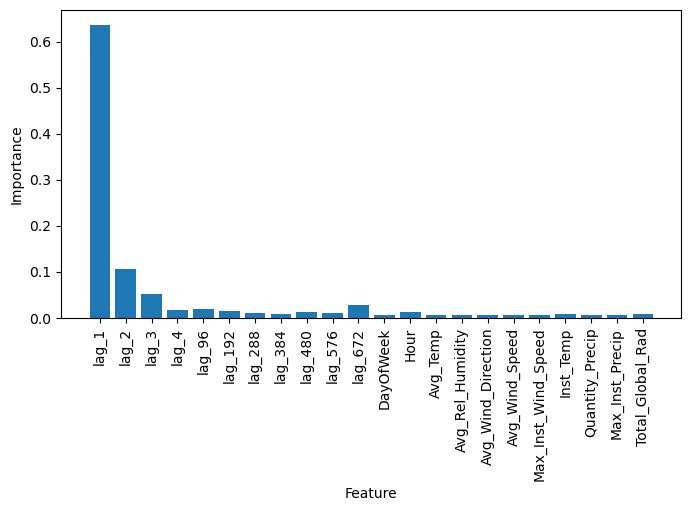

In [10]:
plt.figure(figsize=(8,4))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
#plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.savefig("../../images/main/loureiro_xgb_feat_imp_loc.png")
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

## Hyperparameter Tuning

In [ ]:
df_tuning = pd.read_csv("../../data/loureiro_weather_45houses_selected.csv")
df_tuning.drop(['Time', 'Location'], axis=1, inplace=True)
df_tuning

In [ ]:
undersample_data = df_tuning.loc[np.linspace(df_tuning.index.min(),df_tuning.index.max(),400000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

In [ ]:
params_rf = {
    'bootstrap': [True],
    'max_depth': [8, 12, 16],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 8, 10],
    'n_estimators': [500, 700]
}

In [ ]:
params_xgb = { 
    'max_depth': [10, 16],
    'learning_rate': [0.001, 0.01, 0.05],
    'n_estimators': [500, 700],
    'colsample_bytree': [0.3, 0.7]
}

In [ ]:
train_features = undersample_data.drop('Energy', axis=1)
train_labels = undersample_data['Energy']
test_features = 0
test_labels = 0

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(seed=42, tree_method="gpu_hist")

grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 3, n_jobs = 8, verbose = 2)

In [ ]:
grid_search.fit(train_features, train_labels)

In [ ]:
grid_search.best_params_

In [ ]:
{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 700}

In [ ]:
grid_search.best_score_

In [ ]:
rf_model = cuRF()

grid_search_rf = GridSearchCV(estimator = rf_model, param_grid = params_rf, cv = 3, n_jobs = 8, verbose = 2)

In [ ]:
grid_search_rf.fit(train_features, train_labels)

In [ ]:
grid_search_rf.best_params_

In [ ]:
{'bootstrap': True,
 'max_depth': 12,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
grid_search_rf.best_score_